In [3]:
import sys
sys.path.append('/home/ron/Classes/CV-Systems/cybertruck/')


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from dataset import V2Dataset
from hands_cnn import Hands_VGG16
from wrappers.hands_wrapper import Hands_Inference_Wrapper


BATCH_SZ=64

def per_class_accuracies(model, data_dir='../data/v2_cam1_cam2_split_by_driver', detector=True, batch_size=BATCH_SZ):

    if detector:
        transform = v2.Compose([
        v2.Resize((640,640)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ])
    else:
        transform = v2.Compose([
        v2.Resize((224,224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ])

    test_dataset = V2Dataset(cam1_path=f'{data_dir}/Camera 1/test', cam2_path=f'{data_dir}/Camera 2/test', transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    class_labels = list(test_dataset.classes)

    model.eval()

    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    
    cm = confusion_matrix(all_labels, all_predictions)
    class_accs = cm.diagonal() / cm.sum(axis=1)

    for idx, (label, acc) in enumerate(zip(class_labels, class_accs)):
        print(f'Class {idx} -- "{label}" --: Accuracy = {acc:.2%}')
    
    return cm, class_labels



Check per class accuracy and confusion matrix for Hands Classifier

New https://pypi.org/project/ultralytics/8.0.212 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.208 🚀 Python-3.10.13 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16117MiB)
engine/trainer: task=detect, mode=train, model=../detection/hands_detection/runs/detect/best/weights/best.pt, data=coco8.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, strea

Class 0 -- "c0" --: Accuracy = 17.92%
Class 1 -- "c1" --: Accuracy = 0.00%
Class 2 -- "c2" --: Accuracy = 0.00%
Class 3 -- "c3" --: Accuracy = 0.00%
Class 4 -- "c4" --: Accuracy = 21.76%
Class 5 -- "c5" --: Accuracy = 10.00%
Class 6 -- "c6" --: Accuracy = 12.59%
Class 7 -- "c7" --: Accuracy = 57.34%
Class 8 -- "c8" --: Accuracy = 28.08%
Class 9 -- "c9" --: Accuracy = 30.28%


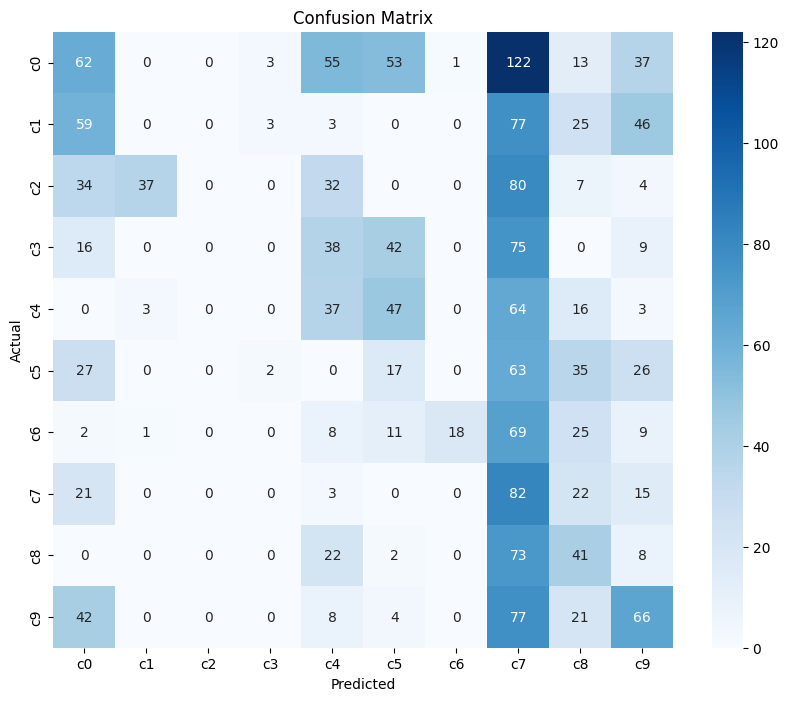

In [4]:
class HandArgs:
    def __init__(self):
        self.freeze = True
        self.num_frozen_params = 30
        self.dropout = 0.35

hand_args = HandArgs()



detector_transform= v2.Compose([
            v2.Resize((640,640)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])

hands_model = Hands_VGG16(hand_args, num_classes=10).to('cuda')
hands_model.load_state_dict(torch.load('/home/ron/Classes/CV-Systems/cybertruck/cnn/hands_models/vgg/epoch60_11-16_03:44:44.pt'))

hands_wrapper = Hands_Inference_Wrapper(hands_model)

hands_cm, class_labels = per_class_accuracies(hands_wrapper)


%matplotlib inline

plt.figure(figsize=(10, 8))
sns.heatmap(hands_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()